In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

변환하고자 하는 이미지를 선택

In [2]:
cat_in_snow  = tf.keras.utils.get_file(
    '320px-Felis_catus-cat_on_snow.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')

image_string = open(cat_in_snow, 'rb').read()
image = tf.io.decode_jpeg(image_string)

32768/17858 [=======================================================] - 0s 0us/step


In [33]:
def test_deprocess(img):
  img = tf.cast(img, dtype=tf.float32) / 255.0
  return tf.cast(img, tf.uint32)

# 이미지를 정규화합니다.
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

**특징 추출이 가능한 모델을 선택 및 불러오기**

딥드림은 활성화시킬 하나 혹은 그 이상의 층을 선택한 후 "손실"을 최대화하도록 이미지를 수정함으로써 선택한 층을 "흥분"시키는 원리를 기반으로 합니다. 얼마나 복잡한 특성이 나타날지는 선택한 층에 따라 다르게 됩니다. 낮은 층을 선택한다면 획 또는 간단한 패턴이 향상되고, 깊은 층을 선택한다면 이미지 내의 복잡한 패턴이나 심지어 물체의 모습도 생성할 수 있습니다.

InceptionV3에는 'mixed0'부터 'mixed10'까지 총 11개의 이러한 합성곱층이 있습니다. 이 중 어떤 층을 선택하느냐에 따라서 딥드림 이미지의 모습이 결정됩니다. 깊은 층은 눈이나 얼굴과 같은 고차원 특성(higher-level features)에 반응하는 반면, 낮은 층은 선분이나 모양, 질감과 같은 저차원 특성에 반응합니다. 임의의 층을 선택해 자유롭게 실험해보는 것도 가능합니다. 다만 깊은 층(인덱스가 높은 층)은 훈련을 위한 그래디언트 계산에 시간이 오래 걸릴 수 있습니다.

In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [7]:
# 선택한 층들의 활성화값을 최대화합니다.
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# 특성 추출 모델을 만듭니다.
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# **손실 계산하기**

손실은 선택한 층들의 활성화값의 총 합으로 계산됩니다. 층의 크기와 상관 없이 모든 활성화값이 동일하게 고려될 수 있도록 각 층의 손실을 정규화합니다. 일반적으로, 손실은 경사하강법으로 최소화하고자 하는 수치입니다. 하지만 딥드림에서는 예외적으로 이 손실을 경사상승법(gradient ascent)을 통해 최대화할 것입니다.

In [32]:
def calc_loss(img, model):
    # 이미지를 순전파시켜 모델의 활성화값을 얻습니다.
    # 이미지의 배치(batch) 크기를 1로 만듭니다.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)

    # (1, 11, 18, 768)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act) # 손실은 선택한 층들의 활성화값의 총 합으로 계산
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [34]:
calc_loss(test_deprocess(image), dream_model)

<tf.Tensor: shape=(), dtype=float32, numpy=0.52035284>

# **경사상승법**

선택한 층의 손실을 구했다면, 이제 남은 순서는 입력 이미지에 대한 그래디언트를 계산하여 원본 이미지에 추가하는 것입니다.

원본 이미지에 그래디언트를 더하는 것은 신경망이 보는 이미지 내의 패턴을 향상시키는 일에 해당합니다. 훈련이 진행될수록 신경망에서 선택한 층을 더욱더 활성화시키는 이미지를 생성할 수 있습니다.

In [35]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # `img`에 대한 그래디언트가 필요합니다.
          # `GradientTape`은 기본적으로 오직 `tf.Variable`만 주시합니다.
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # 입력 이미지의 각 픽셀에 대한 손실 함수의 그래디언트를 계산합니다. 편미분 과정.
        gradients = tape.gradient(loss, img)

        # 편차로 나누어서 그래디언트를 정규화합니다.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # 경사상승법을 이용해 "손실" 최대화함으로써 입력 이미지가 선택한 층들을 보다 더 "흥분" 시킬 수 있도록 합니다.
        # (그래디언트와 이미지의 차원이 동일하므로) 그래디언트를 이미지에 직접 더함으로써 이미지를 업데이트할 수 있습니다.
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [36]:
deepdream = DeepDream(dream_model)

Main loop

In [40]:
# 이미지를 출력합니다.
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # 이미지를 모델에 순전파하기 위해 uint8 형식으로 변환합니다.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

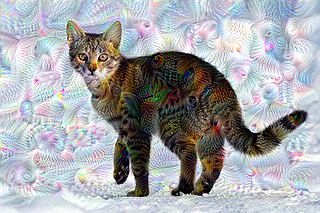

In [41]:
dream_img = run_deep_dream_simple(img=tf.cast(image, dtype=tf.float32), 
                                  steps=100, step_size=0.01)